In [1]:
from sys import path
path.append("..")

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from rdd import measures
from rdd import RDD
from rdd import visualize
from rdd import other_sims
from rdd import ascos
from rdd import cos_sim


In [2]:
G1, G2 = nx.Graph(), nx.Graph()

G2.add_edges_from([
    (1,2),
    (2,4),
    (2,3),
    (3,5),
    (4,5),
    (5,6)
])

G1.add_edges_from([
    (1, 2),
    (2, 3),
    (2, 4),
    (3, 4),
    (3, 6),
    (4, 5),
])

G3 = nx.read_adjlist('../data/facebook_combined.txt', nodetype=int)
G4 = nx.read_gml('../data/karate.gml', label='id')

real_paths1 = nx.single_source_shortest_path(G3, 1, 2)
node_list1 = RDD.populate_node_list(real_paths1)
list_of_nodes = []
for node in node_list1:
    list_of_nodes.append(node.name)
G5 = RDD.nodes_to_graph(G3, list_of_nodes)

target_G = G5
target_rad = 2
measure_list = measures.global_graph_degree

pos = nx.spring_layout(target_G)

In [11]:
tareget_nodes = [1]

# fig = visualize.draw(G4, pos)
fig = visualize.visualize_rdd_vector(target_G, 1, target_rad, pos, [measures.global_graph_degree])
visualize.add_markers(fig, tareget_nodes)
fig.show()

In [12]:
def get_df_for_cluster(g):
    all_rdds_df = pd.DataFrame() 

    for target_one in g.nodes():
        rdd_list = []
        for target_two in g.nodes():
            rdd_list.append(RDD.realworld_distance_compare(target_G, target_one, target_two, measure_list, target_rad))
        all_rdds_df[target_one] = rdd_list
    
    return all_rdds_df



In [13]:
from sklearn_extra.cluster import KMedoids

cluster_df = get_df_for_cluster(target_G)
np_of_rdds = np.array(cluster_df)
kmedoids = KMedoids(n_clusters=2, random_state=0).fit(np_of_rdds)
kmedoids.labels_

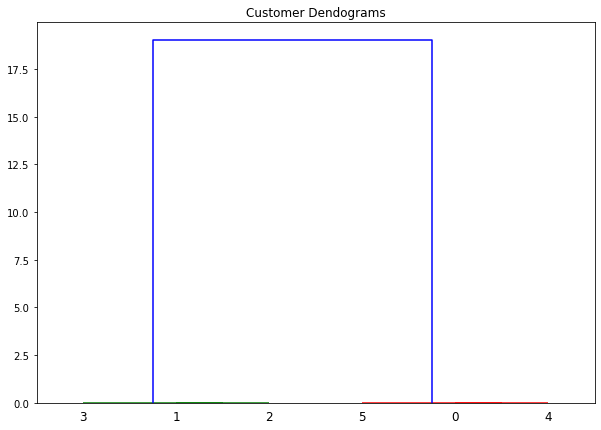

In [6]:
import scipy.cluster.hierarchy as shc

data = get_df_for_cluster(target_G)
plt.figure(figsize=(10, 7))
plt.title("Customer Dendograms")
dend = shc.dendrogram(shc.linkage(data, method='ward'))

In [7]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
cluster.fit_predict(data)

array([0, 1, 1, 1, 0, 0])

In [8]:
other_sims.agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, 3)

,node_name,radius,degree,cluster
0,1,1,1,1
1,2,1,3,0
2,3,1,3,0
3,4,1,3,0
4,6,1,1,1
5,5,1,1,2


# Clusters based of distance matrixs

In [9]:
target_clusters = 7

In [10]:
%%timeit -n1 -r1
fig = visualize.visualize_rdd_kmedoid(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()

17min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [11]:
%%timeit -n1 -r1
fig = visualize.visualize_rdd_agglomerative_hierarchical_clustering(target_G, target_rad, measure_list, pos, target_clusters)
fig.show()

17min 2s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [12]:
%%timeit -n1 -r1
fig = visualize.visualize_rdd_kmeans_matrix(target_G, target_rad, [measure_list], pos, target_clusters)
fig.show()

17min 1s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


# Clustoring on a list of rdds obtained from single root node (target_node = 1) to all others

In [13]:
%%timeit -n1 -r1
fig = visualize.visualize_rdd_vector_kmeans(target_G, 1, target_rad, [measure_list], pos, target_clusters)
fig.show()

3.27 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [14]:
%%timeit -n1 -r1
fig = visualize.visualize_rdd_vector_mean_shift(target_G, 1,target_rad, [measure_list], pos)
fig.show()

3.82 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
